In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Carrega a base de média diária de voos

In [2]:
international_flights_avg = pd.read_csv('jan-media_voos.csv')
international_flights_avg = international_flights_avg[['org', 'dest', 'valor_norm']]
international_flights_avg = international_flights_avg.rename(columns={'org': 'source', 'dest': 'target', 'valor_norm':'value'})

In [3]:
international_flights_avg.head()

,source,target,value
0,Algeria,Austria,1.000000
1,Algeria,Belgium,1.275510
2,Algeria,Canada,1.000000
3,Algeria,France,12.272727
4,Algeria,Germany,1.560345


Constrói o grafo com a probabilidade de voos entre países

In [4]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()

transition_matrix = transition_matrix.set_index('source').join(country_international_flights, lsuffix='_daily_flights', rsuffix='_source_sum_flights')

transition_matrix['prob'] = (transition_matrix['value_daily_flights']/transition_matrix['value_source_sum_flights'])
transition_matrix = transition_matrix.drop(columns=['value_source_sum_flights', 'value_daily_flights']).reset_index()

In [5]:
transition_matrix.head()

,source,target,prob
0,Algeria,Austria,0.027296
1,Algeria,Belgium,0.034816
2,Algeria,Canada,0.027296
3,Algeria,France,0.334996
4,Algeria,Germany,0.042591


In [6]:
transition_matrix.groupby('source')[['prob']].sum()

,prob
source,
Algeria,1.0
Argentina,1.0
Armenia,1.0
Australia,1.0
Austria,1.0
Bahrain,1.0
Bangladesh,1.0
Barbados,1.0
Belarus,1.0


Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [7]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])

daily_cases = total_cases.xs(77, level=1).reindex(transition_matrix['source'].unique())

daily_cases = daily_cases.rename(columns={'Total': 'n_cases'}) 

In [8]:
daily_cases.isna()

,n_cases
Name,
Algeria,False
Argentina,False
Armenia,False
Australia,False
Austria,False
Bahrain,False
Bangladesh,False
Barbados,True
Belarus,False


In [9]:
daily_cases = daily_cases.fillna(0)
daily_cases

,n_cases
Name,
Algeria,58.0
Argentina,65.0
Armenia,52.0
Australia,375.0
Austria,1016.0
Bahrain,221.0
Bangladesh,5.0
Barbados,0.0
Belarus,36.0


In [10]:
#TODO: os nomes das df de voos e  casos parecem estar muito diferentes. eh preciso normaliza-los... veja que tem muito valor nulo no votor abaixo 

state_df_start = total_cases.xs(0, level=1).reindex(transition_matrix['source'].unique())
state_df_start = state_df_start.fillna(0)

state_df_start

,Total
Name,
Algeria,0.0
Argentina,0.0
Armenia,0.0
Australia,0.0
Austria,0.0
Bahrain,0.0
Bangladesh,0.0
Barbados,0.0
Belarus,0.0


Faz o random walk

In [11]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [12]:
transition_matrix = transition_matrix.set_index(['source', 'target'])

In [13]:
def transition_matrix_loss(loss_df):    
    df_joined = transition_matrix.join(loss_df, how='left')

    df_joined['prob'] = df_joined['prob']*df_joined['pct_loss']

    df_joined = df_joined.reset_index()

    df_joined = pd.crosstab(df_joined['target'], df_joined['source'], df_joined['prob'], aggfunc=sum)
    df_joined = df_joined.fillna(0)

    return df_joined

In [14]:
week_loss_df = pd.read_csv('data/week_pct_loss.csv').drop(columns=['Unnamed: 0']).rename(columns={'org': 'source', 'dest':'target'})

In [15]:
def model_spread2(r, p, use_loss=False, day=77):
    state_df = state_df_start
    
    for i in range(1, (day+1)):
        week = int(i/7)
        if(week<5):
            state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
        else:
            if use_loss:
                week_loss = week_loss_df.set_index(['week_value']).loc[week].reset_index().set_index(['source', 'target']).drop(columns=['week_value'])
                transition_matrix_week =transition_matrix_loss(week_loss)
                state_df = state_df*r + (transition_matrix_week.dot(state_df)*p)
            else:
                state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
            
            
    return state_df

Cria o dataframe a ser utilizado e roda o gridsearch

In [16]:
#contamination_rate = np.arange(1.01,1.5,0.02)
#travel_rate = np.arange(0.0000001,0.00005,0.000002)
#
#initial_number = [x for x in range(1500,2510,50)] 
#correlation_df = pd.DataFrame(columns=['V', 'R', 'Euclidean Distance'])
#
#v_min_dist = initial_number[0]
#r_min_dist = contamination_rate[0]
#p_min_dist = travel_rate[0]
#min_dist = np.Inf
#
# p = 0.01
#
#for p in travel_rate:
#    for r in contamination_rate: 
#        state_df = model_spread2(r, p)
#                
#        dist_euclidean = distance.euclidean(daily_cases, state_df)
#        
#        df = pd.DataFrame([{'P': p, 'R': r, 'Euclidean Distance': dist_euclidean}])
#        correlation_df = correlation_df.append(df, ignore_index=True)
#            
#        if abs(dist_euclidean)<abs(min_dist):
#            min_dist = dist_euclidean
#            r_min_dist = r
#            p_min_dist = p
#        
#print('Menor distancia Euclideana: ' + str(min_dist))
#print('P: ' + str(p_min_dist))
#print('R: ' + str(r_min_dist))

In [17]:
from scipy.optimize import leastsq
import numpy as np
import matplotlib.pyplot as plt
import math


# function we would like to fit
func=lambda tpl : model_spread2(tpl[0], tpl[1]).T.values[0]
# ErrorFunc is the diference between the func and the y "experimental" data
ErrorFunc=lambda tpl,cases: func(tpl)-cases # np.sqrt(np.abs(func(tpl)-cases))
#tplInitial contains the "first guess" of the parameters 
tplInitial1=(1.001,0.0000001)
# leastsq finds the set of parameters in the tuple tpl that minimizes
# ErrorFunc=yfit-yExperimental
tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(daily_cases.T.values[0]))
print(" params ",tplFinal1)


state_df_final=pd.DataFrame({'CasesPredicted':func(tplFinal1)}, index=transition_matrix_crosstab.columns)

(' params ', array([1.10950262, 0.00955045]))


In [18]:
#state_df_final = model_spread2(r_min_dist, p)

print(state_df_final.sum())

state_df_final.sort_values('CasesPredicted', ascending=False)

CasesPredicted    155907.26397
dtype: float64


,CasesPredicted
source,
China,80925.202793
Thailand,4645.495425
South Korea,4316.150715
Taiwan,3851.072920
United States,3796.387068
Malaysia,3633.662366
Japan,3536.790989
Singapore,3414.492426
Germany,2730.626342


In [19]:
print(daily_cases.sum())

daily_cases.sort_values('n_cases', ascending=False)

n_cases    166950.0
dtype: float64


,n_cases
Name,
China,81063.0
Italy,27980.0
Spain,13994.0
South Korea,8320.0
France,6633.0
Germany,6012.0
United States,4661.0
Switzerland,2200.0
United Kingdom,1543.0


In [20]:
#pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])
pearsonr(state_df_final['CasesPredicted'].values, daily_cases['n_cases'].values)

(0.9293088875267883, 1.4496666669201987e-31)

In [21]:
#daily_cases.rename_axis("source").index
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

(0.9293088875267883, 1.4496666669201987e-31)

In [22]:
#TODO: daily_cases tem tuplas como indice. ajustar la em cima para que o indice seja simplesmente o nome do pais (nao fazendo essa gambiarra que fiz mas sim usando o pandas do jeito certo para que isto nao aconteca)

#daily_cases.index = [x[0] for x in daily_cases.rename_axis("source").index]

#daily_cases['n_cases'] = daily_cases['n_cases'].astype(float)

#daily_cases

In [23]:
df_results = state_df_final.join(daily_cases)

df_results['Residuals'] = df_results['n_cases'] - df_results['CasesPredicted']

df_results['ResidualsAbs'] = df_results['Residuals'].abs()

df_results.sort_values('Residuals')

,CasesPredicted,n_cases,Residuals,ResidualsAbs
source,,,,
Thailand,4645.495425,177.0,-4468.495425,4468.495425
Taiwan,3851.072920,0.0,-3851.072920,3851.072920
Singapore,3414.492426,243.0,-3171.492426,3171.492426
Malaysia,3633.662366,553.0,-3080.662366,3080.662366
Japan,3536.790989,824.0,-2712.790989,2712.790989
Hong Kong,2494.024418,0.0,-2494.024418,2494.024418
Australia,2425.545536,375.0,-2050.545536,2050.545536
Kazakhstan,1979.359513,11.0,-1968.359513,1968.359513
Russia,2039.479545,93.0,-1946.479545,1946.479545


In [24]:
df_results.corr()

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.929309,-0.009581,0.002559
n_cases,0.929309,1.000000,0.360382,0.312935
Residuals,-0.009581,0.360382,1.000000,0.840865
ResidualsAbs,0.002559,0.312935,0.840865,1.000000


In [25]:
df_results.drop('China').corr()

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.247119,-0.070202,0.367278
n_cases,0.247119,1.000000,0.949246,0.933410
Residuals,-0.070202,0.949246,1.000000,0.841691
ResidualsAbs,0.367278,0.933410,0.841691,1.000000


In [26]:
df_results.corr(method='kendall')

,CasesPredicted,n_cases,Residuals,ResidualsAbs
CasesPredicted,1.000000,0.348023,-0.344869,0.681288
n_cases,0.348023,1.000000,0.310027,0.308410
Residuals,-0.344869,0.310027,1.000000,-0.283702
ResidualsAbs,0.681288,0.308410,-0.283702,1.000000


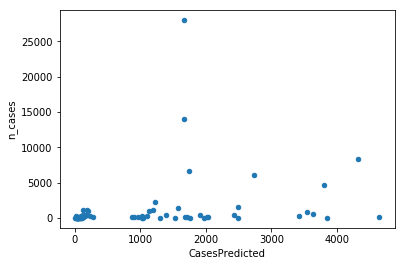

In [27]:
df_results.drop('China').plot.scatter(x='CasesPredicted', y='n_cases')

In [28]:
#state_df_final.join(daily_cases).drop('China').corr(method='kendall')

In [29]:
#correlation_pivot = correlation_df.pivot(index='P', columns='R', values='Euclidean Distance')
#correlation_pivot

In [30]:
#heatmap = sns.heatmap(correlation_pivot.iloc[:,5:6], annot=True)